In [45]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import linear_model
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
pd.options.display.max_columns = 100

/kaggle/input/mlbio1/sample_submission.csv
/kaggle/input/mlbio1/test.csv
/kaggle/input/mlbio1/train.csv


 # 1. Data preparation

### 1.1 Load data

In [2]:
sample = pd.read_csv('/kaggle/input/mlbio1/sample_submission.csv')
test = pd.read_csv('/kaggle/input/mlbio1/test.csv')
train = pd.read_csv('/kaggle/input/mlbio1/train.csv')

### 1.2 Working with miss val

In [3]:
#counts of nan
for i in train.columns:
    print(i, (pd.isnull(train[i])).sum() )
train[train['smoking_status'].isnull()== False]
train["smoking_status"].unique()

# fill with mean
mean_bmi = train['bmi'].mean()
train['bmi'] = train['bmi'].fillna(mean_bmi)
test['bmi'] = test['bmi'].fillna(mean_bmi)

train['smoking_status'] = train['smoking_status'].fillna('nan')
test['smoking_status'] = test['smoking_status'].fillna('nan')

# fill with median
#median_bmi = train['bmi'].median()
#train['bmi'] = train['bmi'].fillna(median_bmi)
#test['bmi'] = test['bmi'].fillna(median_bmi)

id 0
gender 0
age 0
hypertension 0
heart_disease 0
ever_married 0
work_type 0
Residence_type 0
avg_glucose_level 0
bmi 1017
smoking_status 9176
stroke 0


### 1.3 Categorial data

In [5]:
train_d = pd.get_dummies(train)
test_d = pd.get_dummies(test)
all_feat = train_d.columns
train_d.sample(5)

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,gender_Other,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_nan,smoking_status_never smoked,smoking_status_smokes
2615,58235,76.00,0,0,58.65,25.6,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1
29528,1298,48.00,0,0,98.57,29.7,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0
20460,18310,64.00,0,0,104.00,26.0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0
25536,10272,1.08,0,0,98.71,17.3,0,1,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0
12178,11750,53.00,0,0,80.90,24.2,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,1,0


### 1.4 Outliers

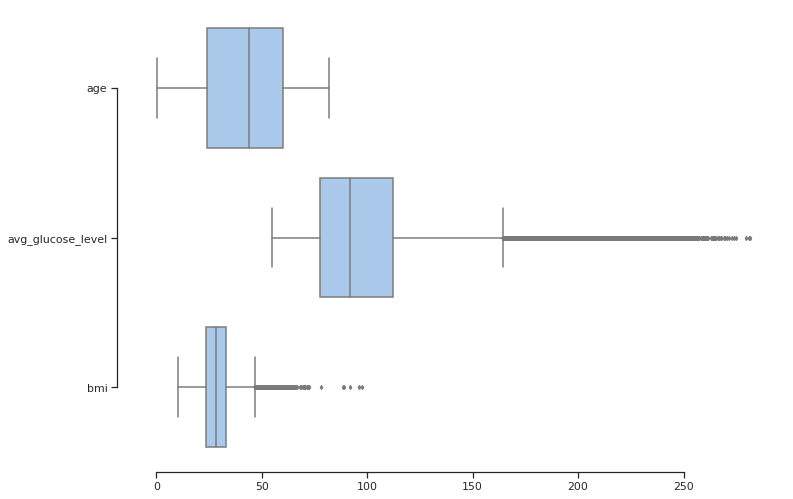

In [8]:
sns.set(style="ticks", palette="pastel",rc={'figure.figsize':(11.7,8.27)})
tips = train_d[["age","avg_glucose_level","bmi"]]

sns.boxplot(orient = "h", palette=["b"], data=tips, fliersize = 3)
sns.despine(offset=10, trim=True)

In [9]:
train_no_outliers = train_d[train_d["bmi"]<2*train_d["bmi"].mean()]
train_no_outliers = train_no_outliers[train_no_outliers["avg_glucose_level"]<2*train_no_outliers["avg_glucose_level"].mean()]
train_no_outliers.shape

(28232, 23)

In [ ]:
#pearson cor

# 2 Cross validation

In [11]:
#from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

In [36]:
def my_cross_validation_for_roc_auc( clf, X, y ,cv=5):
    X = np.array(X.copy())
    y = np.array(y.copy())
    kf = KFold(n_splits=cv)
    kf.get_n_splits(X)
    scores = []
    models = []
    for train_index, test_index in kf.split(X):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        clf.fit(X_train, y_train)
        prediction_on_this_fold = clf.predict_proba(X_test)[:,1]
        
        score = roc_auc_score(y_score=prediction_on_this_fold, y_true=y_test)
        scores.append(score)
        models.append(clf)
    return scores,models

# 3. LGMBClacssifier

In [15]:
#features
f3 = [ 'age', 'hypertension', 'heart_disease', 'avg_glucose_level',
       'bmi', 'ever_married_No', 'ever_married_Yes', 'work_type_Self-employed',
      'work_type_children']
from lightgbm import LGBMClassifier

In [37]:
lgb =   LGBMClassifier(n_estimators=185, max_depth=3,boosting_type='dart',
                       num_leaves=6,learning_rate=0.15,reg_lambda=0.46)
scores, models = my_cross_validation_for_roc_auc(lgb, train_no_outliers[f3] , train_no_outliers['stroke'])
print (scores, np.mean(scores))

[0.8573062163538484, 0.8647515900122407, 0.8579354378082416, 0.8668245957359151, 0.8584210026934971] 0.8610477685207485


In [44]:
for reg in models:
    print(roc_auc_score(y_score=reg.predict_proba(train_no_outliers[f3])[:,1], y_true=train_no_outliers["stroke"]))

0.8882126203386617
0.8882126203386617
0.8882126203386617
0.8882126203386617
0.8882126203386617


# 4. Fitting and Prediction

In [46]:
lgb.fit(train_no_outliers[f3] , train_no_outliers['stroke'])
prediction = lgb.predict_proba(test_d[f3])[:,1]
sample['stroke'] = prediction

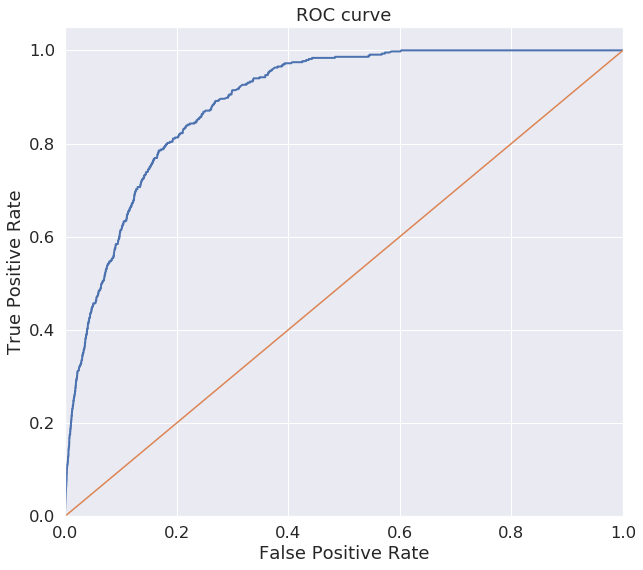

In [32]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")
import sklearn.metrics as metrics
plt.figure(figsize=(10, 9))
fpr, tpr, thresholds = metrics.roc_curve(train_no_outliers['stroke'], lgb.predict_proba(train_no_outliers[f3])[:,1])
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

In [19]:
sample.to_csv('submi4.csv', index = None )

In [ ]:
#[0.8470874451050663, 0.8482760125478559, 0.8463047651309847, 0.8388232478547348, 0.8356180938962395] 0.85776
#LGBMClassifier(n_estimators=100, max_depth=5)
#[0.8482923097460542, 0.8525358384287318, 0.8578461989046974, 0.8444127652098369, 0.8442989601929999] 0.86024
#LGBMClassifier(n_estimators=100, max_depth=4)
#[0.8521627662596826, 0.8585328273461352, 0.8576318315266486, 0.8592570458629548, 0.8485701697622228] 0.86747
#LGBMClassifier(n_estimators=150, max_depth=3,boosting_type='dart',num_leaves=31)
#[0.8532058983600834, 0.859950251678838, 0.8582643476174344, 0.8565262681723295, 0.8526975778631408]0.86882
#LGBMClassifier(n_estimators=150, max_depth=3,boosting_type='dart',num_leaves=31,learning_rate=0.15) 0.86882
#[0.857735265224252, 0.8599443772144633, 0.8581329042457092, 0.8553476346402056, 0.8530165417582636] 0.86759
#LGBMClassifier(n_estimators=150, max_depth=3,boosting_type='dart',num_leaves=31,learning_rate=0.15,reg_alpha=0.5) 

#[0.8573062163538484, 0.8647515900122407, 0.8579354378082416, 0.8668245957359151, 0.8584210026934971] 0.87502
#lgb =   LGBMClassifier(n_estimators=185, max_depth=3,boosting_type='dart',num_leaves=6,learning_rate=0.15,reg_lambda=0.46)  NO OUTLIERS